# **Table of Contents:**

1.   Introduction
2.   Two Model Approach
3.   State of the art Causal Neural Networks
4.   Motivation for DRAGONNET
5.   DRAGONNET

    


# 1.Introduction
Targeting the right customers is one of the biggest challenges that marketeers face. As a marketeer, to create an effective marketing campaign that target the right people, it is important to identify who these people are. Individuals differ not only in their characteristics, but also in how they respond to a particular treatment, which could be promotion emails, coupons, ads, etc. Therefore, our aim in this tutorial is to predict the heterogeneous treatment effects, by using neural networks. First, we present an overview of the current state-of-the-art estimation methods. Then, we illustrate one of the most recent neural network models in estimating heterogeneous treatment effects - Dragonnet-. Finally, we present the results and discuss how our proposed model could improve estimation quality.







#### 1.1. For estimating treatment effects, there are two metrics:

####a. Conditional Average Treatment Effect (CATE)

Conditional Average Treatment Effect, or CATE, is designed to capture heterogeneity of a treatment effect on an outcome of interest across subpopulations with a particular set of features. In other words, it measures the treatment effect on a group within the sample population because of heterogeneous effects in the population, meaning that treatment can have a different effect on different groups of people.
It is particularly helpful in our context, where marketers could target the group that could respond more positively to a certain marketing campaign such as ads, emails, coupons, etc.
Formally, CATE can be calculated as:

τ(x)=E[Y(1)−Y(0)∣X=x]

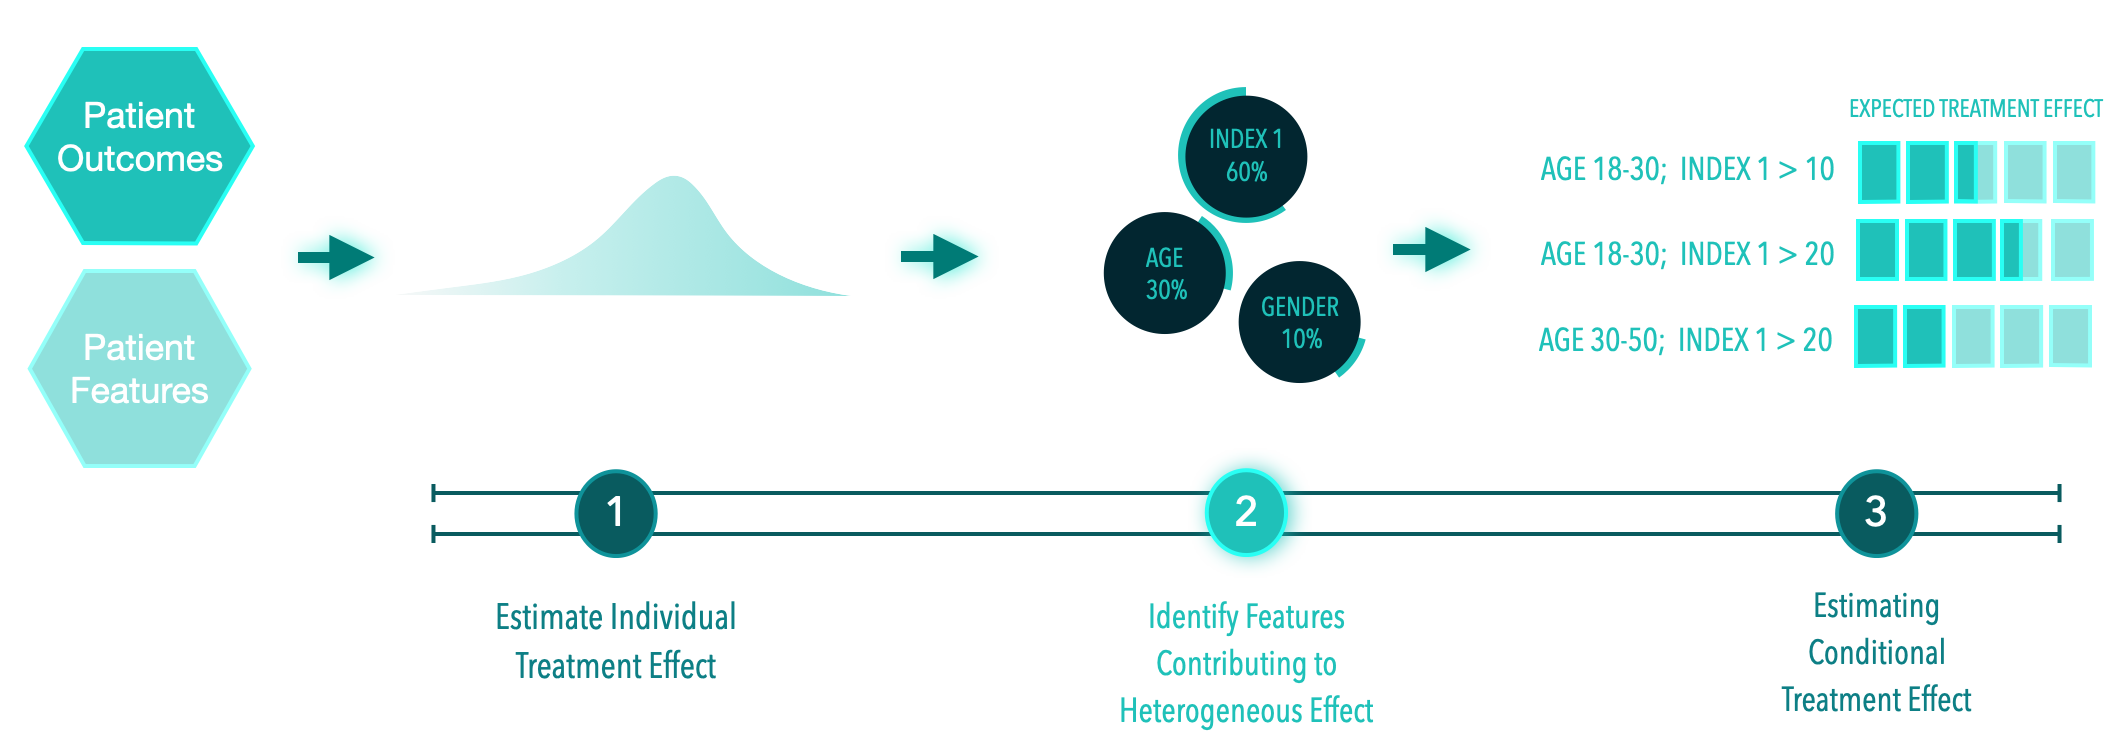

It reports the heterogeneity in terms of the difference probabilities under treatment and control conditions

####b.  Uplift

Uplift is used to model the incremental impact of an action or treatment on the outcome of an individual. It is often used in the context of binary outcomes such as purchase, visit the website or employment status. In other words, it refers to the set of techniques that a company may use to estimate customer uplift, that is, the effect of an action on some customer outcome. For example, the difference in the probability of an outcome of customer given a treatment, such as promotion emails, in comparison to no treatment. With that information at hand, marketeers can take decisions with respect to the costs.

Lift=P (outcome | treatment)−P (outcome |no treatment)

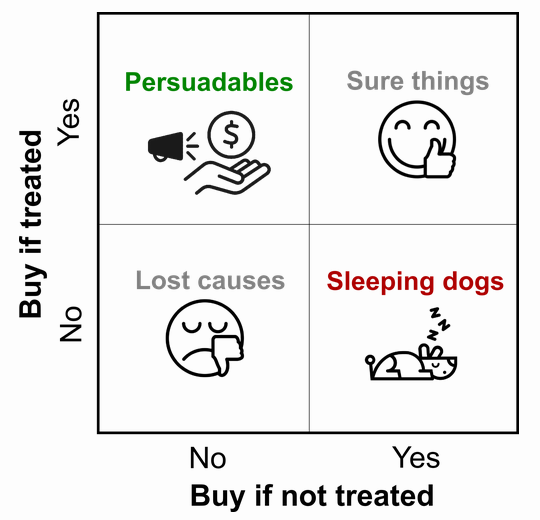

The goal of uplift modeling is to identify the “persuadables”, not waste efforts on “sure things” and “lost causes”, and avoid bothering “sleeping dogs”.

### 1.2. Direct vs Indirect models
Approaches for the estimation of CATE and uplift can be classified into two categories: Direct and indirect


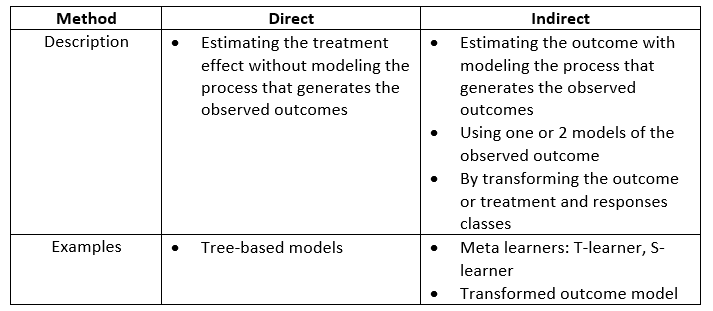

Dragonnet, which we will present later in the tutorial, is a CATE indirect model.

#2.Two Model Approach

##Data Generation

In [308]:
#@title Libraries

# Main imports
!pip install econml
from econml.data.dgps import ihdp_surface_B

# Helper imports 
import numpy as np
from numpy.random import binomial, multivariate_normal, normal, uniform

import pandas as pd
from sklearn.model_selection  import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.optimizers import adam
import tensorflow as tf

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import pandas as pd

import tensorflow as tf
import keras.backend as K
from keras.engine.topology import Layer
from keras.metrics import binary_accuracy

import numpy as np
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Concatenate
from keras import regularizers
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

The data generation process below was used in Künzel et al.(2019), that compares meta learneers. This process can be summarized by the formulas below.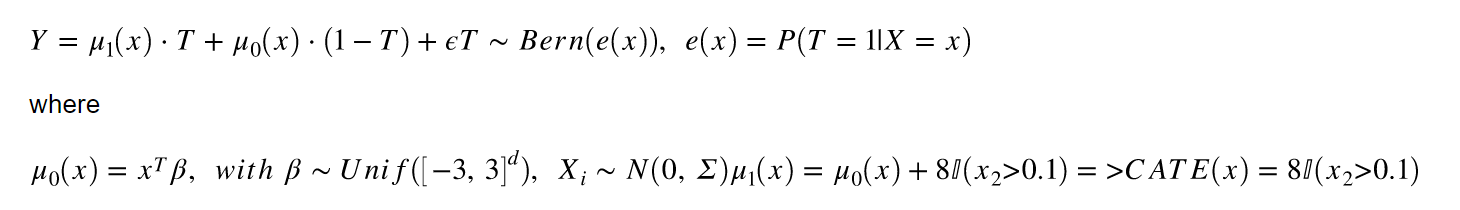

The main function starts with creating covariate matrix by drawing n ( population size ) numbers from standard normal distribution. Then, treatment binary values (wheter a person is treated or not) is calculated by applying propensity function on covariates matrix(see treatment_effect lambda function below), which makes the probabilty of treatment conditional on covariate matrix. Treatment effect for each person is simulated in the same manner: it is 0 if x[1] >= 0.1 (see propensity lambda function below) . 
Lastly, y values are first drawn from a random uniform distribution and the simulated treatment effect value is added on the drawn y values to finalize the value of outcome variable.


In [309]:
#Data generation process in Künzel et al.(2019)
def generate_data(n, d, controls_outcome, treatment_effect, propensity):
    # Generate covariates
    X = np.random.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    # Generate treatment
    T = np.apply_along_axis(lambda x: np.random.binomial(1, propensity(x), 1)[0], 1, X)
    # Calculate outcome
    Y0 = np.apply_along_axis(lambda x: controls_outcome(x), 1, X)
    treat_effect = np.apply_along_axis(lambda x: treatment_effect(x), 1, X)
    Y = Y0 + treat_effect * T
    return (Y, T, X,treat_effect)

# controls outcome, treatment effect, propensity definitions
def generate_controls_outcome(d):
    beta = np.random.uniform(-3, 3, d)
    return lambda x: np.dot(x, beta) + np.random.normal(0, 1)
treatment_effect = lambda x: (1 if x[1] > 0.1 else 0)*8
propensity = lambda x: (0.8 if (x[2]>-0.5 and x[2]<0.5) else 0.2)

In [310]:
# DGP constants and test data
d = 5
n = 1000
n_test = 250
controls_outcome = generate_controls_outcome(d)
X_test = np.random.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n_test)
delta = 6/n_test
X_test[:, 1] = np.arange(-3, 3, delta)

Y, T, X,treat = generate_data(n, d, controls_outcome, treatment_effect, propensity)

We have merged all of the variables and target in one dataframe so that train-test split process will be more convenient and safe. 

In [311]:
data=pd.DataFrame(np.column_stack([X, Y, T, treat]))
data.rename(columns={5: "Y", 6: "T", 7: "treatment_effect"},inplace=True)

In [312]:
data

,0,1,2,3,4,Y,T,treatment_effect
0,-0.339679,-0.577906,1.137568,1.876374,1.237329,0.243380,0.0,0.0
1,0.392644,0.688694,-0.305104,1.382529,-0.102005,6.614743,1.0,8.0
2,0.689565,-0.223647,0.386250,-1.366810,-0.164625,-2.186069,1.0,0.0
3,1.457246,-0.166662,1.217261,0.233863,-0.326678,-0.712764,0.0,0.0
4,0.038385,0.688996,1.568372,0.448226,0.899095,0.043772,0.0,8.0
...,...,...,...,...,...,...,...,...
995,-0.848887,-0.207300,-0.914479,-0.558599,-0.005447,-1.594228,0.0,0.0
996,0.969903,-0.724995,-0.007550,0.071267,0.330910,-2.062312,1.0,0.0
997,0.200693,-0.169024,-0.703798,-1.227847,0.913335,-3.084058,0.0,0.0
998,0.667452,-0.771174,1.495994,-1.221756,0.623511,1.336872,0.0,0.0


30% of the data is used as a validation set. Thre remaning 70% is not used as training set because the number of treated and untreated observations wasn't equal. Therefore X_train is further subsetted in order to have the same number of observations in treatment and control groups.


In [313]:
X_train,X_val,y_train,y_val = train_test_split(data, data['Y'], test_size=0.3, random_state= 15)
n1=len(X_train[X_train['T'] == 1])
n0=len(X_train[X_train['T'] == 0])
df1 = X_train.loc[X_train['T'] == 1].sample(min(n0,n1)).reset_index()
df0 = X_train.loc[X_train['T'] == 0].sample(min(n0,n1)).reset_index()

X_train=pd.concat([df1,df0])
X_train = X_train.sample(frac=1).reset_index(drop=True)
X_train.drop('index',axis=1,inplace=True)

cols=[0,	1,	2,	3,	4 ]

X_treatment=df1[cols]
Y_1=df1['Y']

X_control=df0[cols]
Y_0=df0['Y']

##2 Model Approach with NNs

Two model approach is one of the simplest and easy to understand approaches in predicting CATE. It doesn't predict CATE directly, it has two models, as name suggests, each predicting the outcome variable (which could be whether a customer responded or the amount of money that the customer spent) seperately. The difference between models is that one of the models is trained using only the treated observations and the other is trained using only the control group observations. The final CATE estimation is the difference between the predictions of these two models.

In [ ]:
def sse(y_true,y_pred):
  sse= tf.square(y_true-y_pred)
  return sse

In [ ]:
# define the keras model for treatment group

model_t = Sequential()
model_t.add(Dense(200, input_dim=X_treatment.shape[1], activation='elu',kernel_regularizer=regularizers.l2(0.01)))
model_t.add(Dense(200, activation='elu',kernel_regularizer=regularizers.l2(0.01)))
model_t.add(Dense(200, activation='elu',kernel_regularizer=regularizers.l2(0.01)))
model_t.add(Dense(100, activation='elu',kernel_regularizer=regularizers.l2(0.01)))
model_t.add(Dense(100, activation='elu',kernel_regularizer=regularizers.l2(0.01)))
model_t.add(Dense(1, activation=None, kernel_regularizer=regularizers.l2(0.01)))

model_t.compile(loss=sse, optimizer=adam(lr=1e-3), metrics=[sse])
adam_callbacks = [TerminateOnNaN(),
                 EarlyStopping(monitor='val_loss', patience=2, min_delta=0.),
                 ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=True, mode='auto',
                 min_delta=1e-8, cooldown=0, min_lr=0) ]
  
# define the keras model for treatment group
model_c = Sequential()
model_c.add(Dense(200, input_dim=X_control.shape[1], activation='elu',kernel_regularizer=regularizers.l2(0.01)))
model_c.add(Dense(200, activation='elu',kernel_regularizer=regularizers.l2(0.01)))
model_c.add(Dense(200, activation='elu',kernel_regularizer=regularizers.l2(0.01)))
model_c.add(Dense(100, activation='elu',kernel_regularizer=regularizers.l2(0.01)))
model_c.add(Dense(100, activation='elu',kernel_regularizer=regularizers.l2(0.01)))
model_c.add(Dense(1, activation=None, kernel_regularizer=regularizers.l2(0.01)))

model_c.compile(loss=sse, optimizer=adam(lr=1e-3), metrics=[sse])
adam_callbacks = [TerminateOnNaN(),
                 EarlyStopping(monitor='val_loss', patience=2, min_delta=0.),
                 ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=True, mode='auto',
                 min_delta=1e-8, cooldown=0, min_lr=0) ]


In [ ]:
model_t.fit(X_treatment,Y_1,callbacks=adam_callbacks, validation_split=0.2,epochs=30,batch_size=64,verbose=False)
model_c.fit(X_control,Y_0,callbacks=adam_callbacks, validation_split=0.2,epochs=30,batch_size=64,verbose=False)

In [ ]:
CATE=model_t.predict(X_val[cols])-model_c.predict(X_val[cols])

In [ ]:
pd.DataFrame(CATE).to_csv('CATE.csv')
pd.DataFrame(y_val).to_csv('y_val.csv')
pd.DataFrame(X_val['T']).to_csv('t_val.csv')


##Performance Measures

We evaluate treatment models by looking at cumulative gain charts. (i.e. QINI Curves) These charts are constructed by sorting the population from the highest treatment effect to the lowest. Below you can see the QINI Curves for 2 model approach and Dragonnet. The x-axis represents the proportion of population targeted and the y-axis represents the cumulative incremental gains. We report QINI Score, which is the area between uplift curve of our models and the random curve. A QINI Score near 1 corresponds to a good performance, whereas a QINI Score near 0 corresponds to a worse one. We cannot say Dragonnet is clearly superior to two model approach only by looking at uplift curves and QINI Scores, but this can be due to a lack of Dragonnet-tuning. Moreover, we use 2 model approach with NN as a benchmark, which is a good predictor without any tuning. 

QINI Curve AUC Score for 2 Model Approach: 0.6979

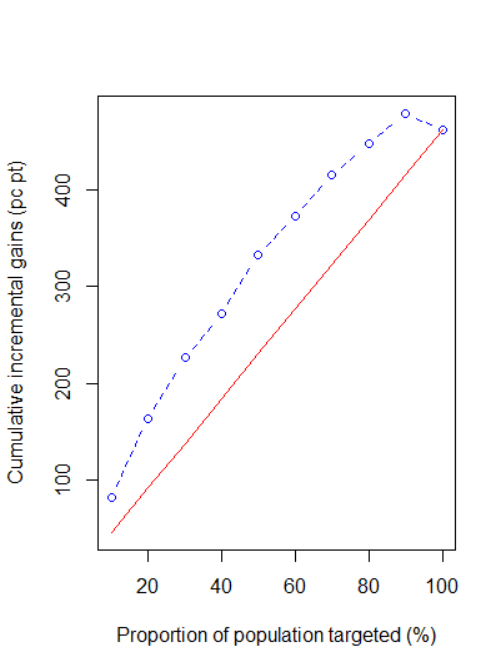

QINI Curve AUC Score for Dragonnet: 0.7054

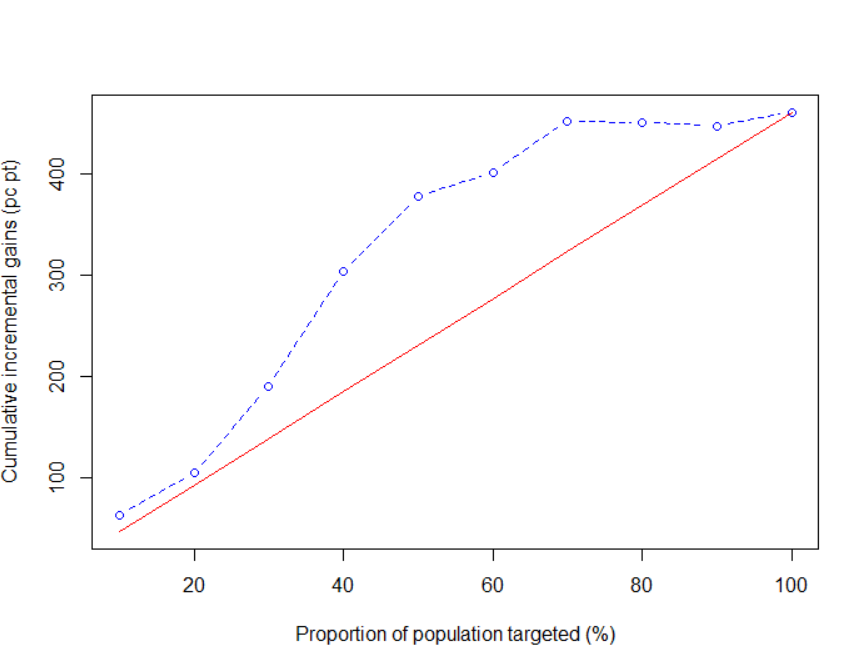

# 3. State-of-the-art Causal Neural Networks
We present the current related state-of-the-art networks. Looking at the table, novel aproaches in neural networks has been presented in the past few years and in different domains. Neural networks are mostly designed to estimate  the Individual Treatment Effect(ITE) and overcome its problems. In medicine, for example, ITE estimating could help medications to get better outcomes for new patients.

We defined CATE briefly before. To understand CATE estimates, we consider a new unit i with covariate vector xi, in order to
decide whether to give the unit the treatment, we wish to
estimate the Individual Treatment Effect (ITE) of unit i,
Di, which is defined as:
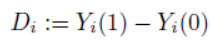

However, we do not observe Di for any unit, and Di is not
identifiable without strong additional assumptions in the
sense that one can construct data-generating processes
with the same distribution of the observed data, but a
different Di. Instead, we will estimate the
CATE function, which is defined as:

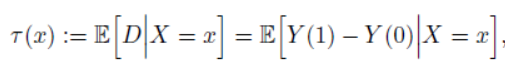


There are other contributions in the literature for average-level treatment effects: ATE, ATT or ATC and learning causal effects as response curves.

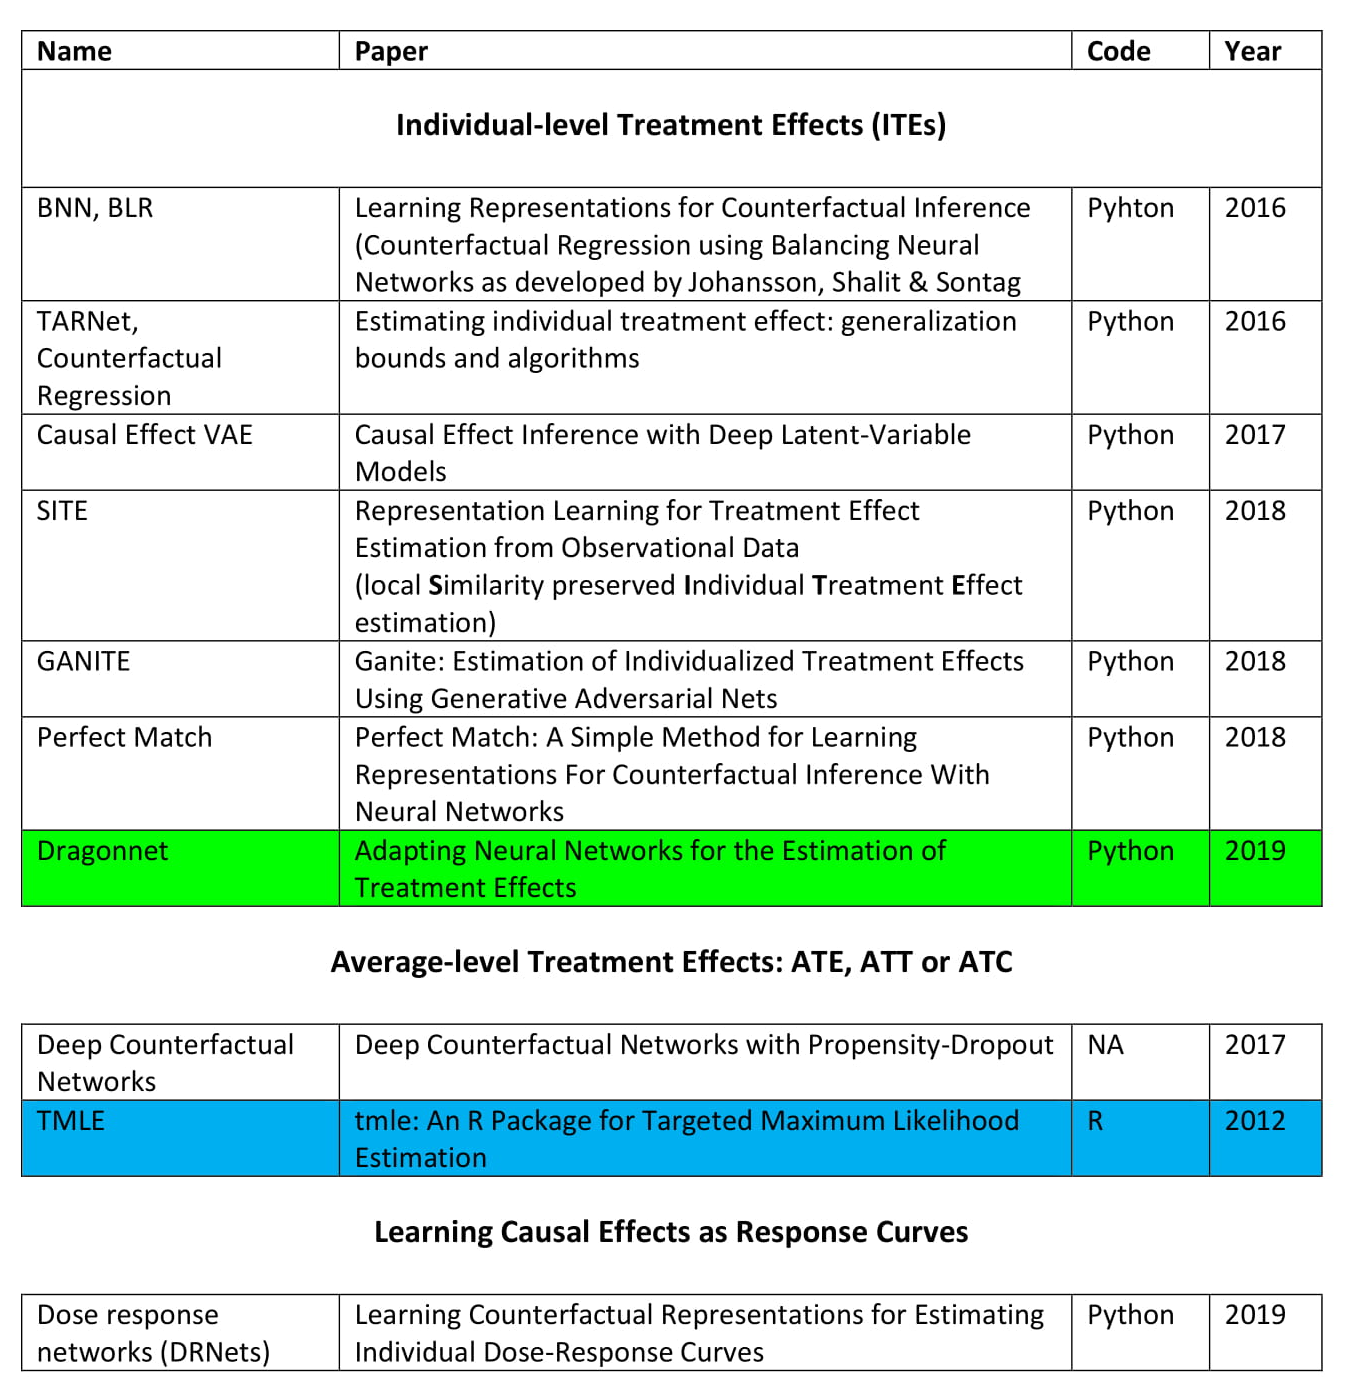

#4.Motivation for DRAGONNET
We looked at several state-of-the-art causal neural networks for average treatment estimation before deciding on Dragonnet to present in our tutorial. Dragonnet is an extension to a 2-headed approach called TARNEt.

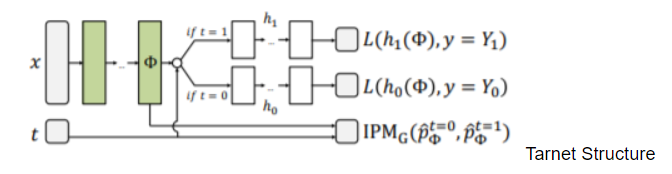

We won’t dive into TARNEt, but as you can see it is similar to the 2 model approach with the usage of 2 neural networks for different conditions. (t=0 & t=1) However it introduces IPMg as a distance measure between p(x|t = 0) and p(x|t = 1), as you know 2 model approach doesn’t take probability discrepancies into account. Dragonnet solves the same problem with different and comparably better results. (Shi et al.) reports the following results:

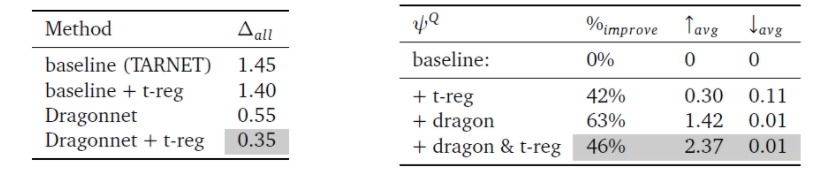

Where ∆ denotes mean absolute error for treatment estimation. We will talk about t-reg after Dragonnet, which is a modification to the objective function used for network training. We chose the sophisticated Dragonnet approach because of its superior predictive properties and remarkably better reported results with semi-synthetic datasets. (IHDP and ACIC18) This improvement is due to the idea behind the Dragonnet:
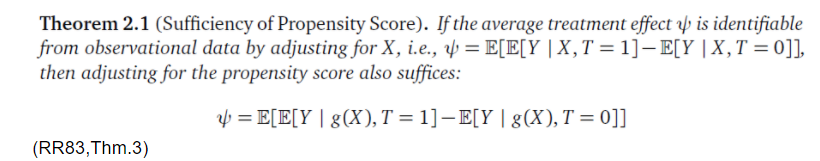

This means we only use the covariates in X, which are relevant to propensity score estimation.(even though this may deteriorate our outcome estimates) The parts in X, which are relevant for outcome estimation but not for treatment estimation, are irrelevant for causal effect and conditioning on these parts hurt finite-sample performance. In a related matter, there is evidence that Dragonnet estimates treatment effect better than TARNET, but is inferior at predicting outcome.

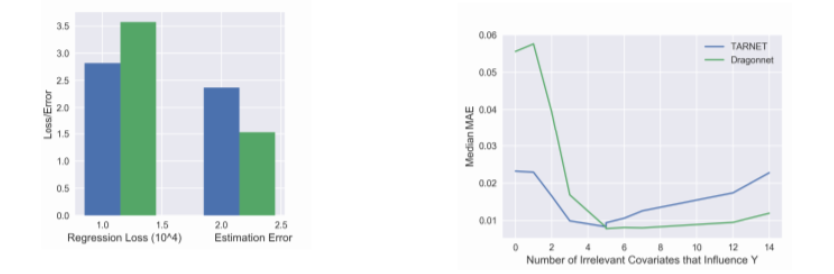

#5.DRAGONNET

Dragonnet is a novel method to improve CATE estimation. It does so by trying to optimize predictions of outcome and propensity score at the same time. We first create a representation layer using a deep net. Representation layer contains processed information with most important task-specific features and connections from a given data set. We use this representation layer to predict both outcomes and treatment. The idea is that the input of the last layer of NN for treatment estimation (representation layer) contains only relevant and important information for output estimation.Therefore, feeding outcome prediction models with representation layer gives much better results than using raw data. We use a simple linear map (sigmoid) for treatment prediction, which gives us propensity score ˆg and couples the representation layer tightly to these estimated propensity scores. Meanwhile we feed the information from the representation layer to 2 hidden layer NNs for each of the outcome models (Q(0,.) & Q(1,.))


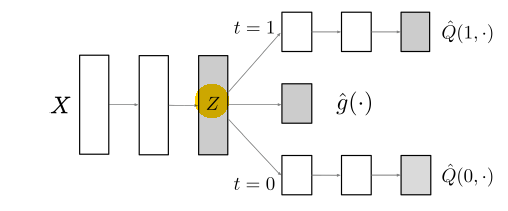

On the figure above you can see the three headed structure of Dragonnet with parameters and output heads Q(ti, xi ;) and g^(xi;). We train this model (only one outcome model for each sampling unit) by minimizing the objective function:

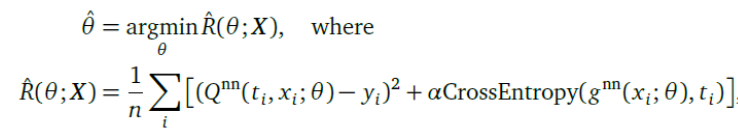
		

With the help of two outcome model Q, we can estimate treatment effect with a downstream estimator such as:

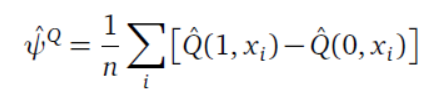

After observing empirical evidence, it was confirmed that Dragonnet trade off treatment prediction accuracy for the sake of better estimation of propensity score.

##Neural Network Loss Functions

In [314]:
#@title Pd_to_Np

def convert_pd_to_np(*args):
    output = [obj.to_numpy() if hasattr(obj, "to_numpy") else obj for obj in args]
    return output if len(output) > 1 else output[0]

In [315]:
#@title Binary Classification Loss Function
#Implements a classification (binary cross-entropy) loss function for DragonNet architecture,
#gives us a measure for treatment estimation.(propensity score estimation)

def binary_classification_loss(concat_true, concat_pred):
  ''' 
    Args:
        - concat_true (tf.tensor): tensor of true samples, with shape (n_samples, 2)
                                   Each row in concat_true is comprised of (y, treatment)
        - concat_pred (tf.tensor): tensor of predictions, with shape (n_samples, 4)
                                   Each row in concat_pred is comprised of (y0, y1, propensity, epsilon)
    Returns:
        - (float): binary cross-entropy loss ''' 
  t_true = concat_true[:, 1]
  t_pred = concat_pred[:, 2]
  t_pred = (t_pred + 0.001) / 1.002
  losst = tf.reduce_sum(K.binary_crossentropy(t_true, t_pred))

  return losst

In [316]:
#@title Regression Loss Function


#Define loss function for outcome predictions. 

def regression_loss(concat_true, concat_pred):
   

    y_true = concat_true[:, 0]
    t_true = concat_true[:, 1]

    y0_pred = concat_pred[:, 0]
    y1_pred = concat_pred[:, 1]

    loss0 = tf.reduce_sum((1. - t_true) * tf.square(y_true - y0_pred))
    loss1 = tf.reduce_sum(t_true * tf.square(y_true - y1_pred))

    return loss0 + loss1

We set regression loss of each outcome prediction to be the sum of squared error. Then we calculate binary classification loss caused by treatment estimation using cross entropy formula.

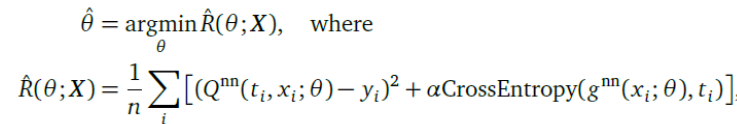

Above you can see the formula for objective function of Dragonnet without using targeted regularization. It consists of sum of squared error of both outcomes plus binary classification loss times a parameter called alpha. (In our code we set alpha=1)

In [317]:
#@title Dragonnet Loss Function
#Define the loss function that will be optimized by dragonnet if targeted regularization is not used.This function aggregated the binary and regression losts  
#This function is an input to targeted regularization if targeted regularization is chosen

def dragonnet_loss_binarycross(concat_true, concat_pred):
   
    return regression_loss(concat_true, concat_pred) + binary_classification_loss(concat_true, concat_pred)

In [318]:
#@title Treatment Accuracy

#Define a function to calculate how good we classify for treatment. (binary classification)
def treatment_accuracy(concat_true, concat_pred):
   
    t_true = concat_true[:, 1]
    t_pred = concat_pred[:, 2]
    return binary_accuracy(t_true, t_pred) 

##Targeted Regularization Functions

Targeted regularization is a method to assure our downstream treatment effect estimator has good asymptotic properties (e.g. robustness, efficiency) by altering objective function. Our new objective function becomes:

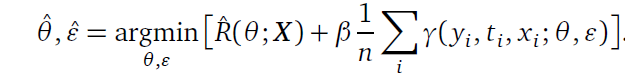

Newly added regularization term is defined by the functions:

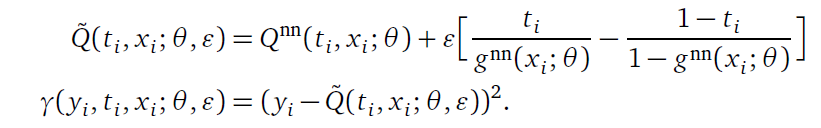

Here you can see that, we have a new parameter called epsilon. Afterwards we define the outcome and treatment effect estimators as follows:

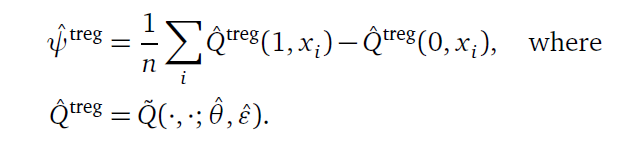

These changes in our estimator and objective function ensures that our estimator is robust and efficient. We can tell this by looking if Q and g are consistent estimators and if Q g and treatment effect estimators satisfy the non-parametric estimating equation:

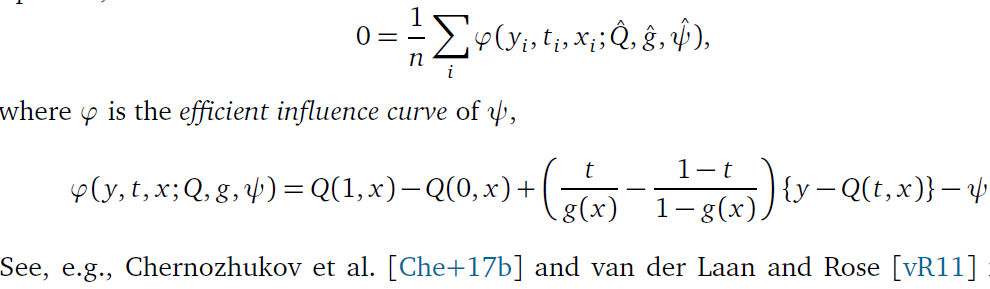

In [319]:
#@title Track Epsilon

def track_epsilon(concat_true, concat_pred):
   
    epsilons = concat_pred[:, 3]
    return tf.abs(tf.reduce_mean(epsilons))

In [320]:
#@title Targeted Regularization Loss Function

def make_tarreg_loss(ratio=1., dragonnet_loss=dragonnet_loss_binarycross):

    def tarreg_ATE_unbounded_domain_loss(concat_true, concat_pred):
        
        vanilla_loss = dragonnet_loss(concat_true, concat_pred)

        y_true = concat_true[:, 0]
        t_true = concat_true[:, 1]

        y0_pred = concat_pred[:, 0]
        y1_pred = concat_pred[:, 1]
        t_pred = concat_pred[:, 2]

        epsilons = concat_pred[:, 3]
        t_pred = (t_pred + 0.01) / 1.02
        # t_pred = tf.clip_by_value(t_pred,0.01, 0.99,name='t_pred')

        y_pred = t_true * y1_pred + (1 - t_true) * y0_pred

        h = t_true / t_pred - (1 - t_true) / (1 - t_pred)

        y_pert = y_pred + epsilons * h
        targeted_regularization = tf.reduce_sum(tf.square(y_true - y_pert))

        # final
        loss = vanilla_loss + ratio * targeted_regularization
        return loss

    return tarreg_ATE_unbounded_domain_loss

In [321]:
#@title Epsilon Layer

class EpsilonLayer(Layer):
    
    def __init__(self):
        
        super(EpsilonLayer, self).__init__()

    def build(self, input_shape):
        
        self.epsilon = self.add_weight(name='epsilon',
                                       shape=[1, 1],
                                       initializer='RandomNormal',
                                       trainable=True)
        super(EpsilonLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        return self.epsilon * tf.ones_like(inputs)[:, 0:1]

##DragonNet Class

We first get the necessary arguments for neural network creation and a binary input indicating if we are working with targeted regularization loss function. We talked about this architecture above, we use functional keras layers stacked on top of each other. Firstly, we create the hidden shared layers for representation learning. This representation will be used for two outcome models, which consist of 3 dense layers each, as well as for treatment estimation. For treatment estimations we use a single layer with sigmoid activation function.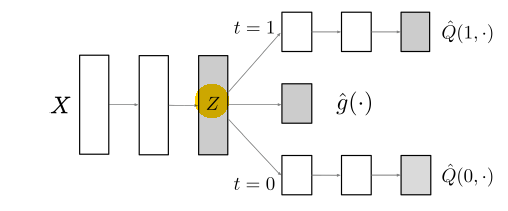

In [322]:
 class DragonNet(object):
    def __init__(self, neurons_per_layer=200, targeted_reg=True, ratio=1., val_split=0.2,
                 batch_size=64, epochs=30, learning_rate=1e-3, reg_l2=0.01, loss_func=dragonnet_loss_binarycross,
                 verbose=True):
        
        self.neurons_per_layer = neurons_per_layer
        self.targeted_reg = targeted_reg
        self.ratio = ratio
        self.val_split = val_split
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.loss_func = loss_func
        self.reg_l2 = reg_l2
        self.verbose = verbose
        
    def make_dragonnet(self, input_dim):
        
        inputs = Input(shape=(input_dim,), name='input')
        
        # representation
        x = Dense(units=self.neurons_per_layer, activation='elu', kernel_initializer='RandomNormal')(inputs)
        x = Dense(units=self.neurons_per_layer, activation='elu', kernel_initializer='RandomNormal')(x)
        x = Dense(units=self.neurons_per_layer, activation='elu', kernel_initializer='RandomNormal')(x)

        t_predictions = Dense(units=1, activation='sigmoid')(x)

        # HYPOTHESIS
        y0_hidden = Dense(units=int(self.neurons_per_layer / 2),
                          activation='elu',
                          kernel_regularizer=regularizers.l2(self.reg_l2))(x)
        y1_hidden = Dense(units=int(self.neurons_per_layer/2),
                          activation='elu',
                          kernel_regularizer=regularizers.l2(self.reg_l2))(x)

        # second layer
        y0_hidden = Dense(units=int(self.neurons_per_layer/2),
                        activation='elu',
                        kernel_regularizer=regularizers.l2(self.reg_l2))(y0_hidden)
        y1_hidden = Dense(units=int(self.neurons_per_layer / 2),
                        activation='elu',
                        kernel_regularizer=regularizers.l2(self.reg_l2))(y1_hidden)

        # third
        y0_predictions = Dense(units=1,
                               activation=None,
                               kernel_regularizer=regularizers.l2(self.reg_l2),
                               name='y0_predictions')(y0_hidden)
        y1_predictions = Dense(units=1,
                               activation=None,
                               kernel_regularizer=regularizers.l2(self.reg_l2),
                               name='y1_predictions')(y1_hidden)

        dl = EpsilonLayer()
        epsilons = dl(t_predictions, name='epsilon')
        concat_pred = Concatenate(1)([y0_predictions, y1_predictions, t_predictions, epsilons])
        model = Model(inputs=inputs, outputs=concat_pred)

        return model

    def fit(self, X, treatment, y):

        """
        Fits the DragonNet model.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        y = np.hstack((y.reshape(-1, 1), treatment.reshape(-1, 1)))

        self.dragonnet = self.make_dragonnet(X.shape[1])

        metrics = [regression_loss, binary_classification_loss, treatment_accuracy, track_epsilon]
        
        #We choose which loss function to use (with or without targeted regularization)
  
        if self.targeted_reg:
            loss = make_tarreg_loss(ratio=self.ratio, dragonnet_loss=self.loss_func)
        else:
            loss = self.loss_func

        self.dragonnet.compile(
            optimizer=Adam(lr=self.learning_rate),
            loss=loss, metrics=metrics)

        adam_callbacks = [
            TerminateOnNaN(),
            EarlyStopping(monitor='val_loss', patience=2, min_delta=0.),
            ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=self.verbose, mode='auto',
                              min_delta=1e-8, cooldown=0, min_lr=0)

        ]

        self.dragonnet.fit(X, y,
                           callbacks=adam_callbacks,
                           validation_split=self.val_split,
                           epochs=self.epochs,
                           batch_size=self.batch_size,
                           verbose=self.verbose)

        sgd_callbacks = [
            TerminateOnNaN(),
            EarlyStopping(monitor='val_loss', patience=40, min_delta=0.),
            ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=self.verbose, mode='auto',
                              min_delta=0., cooldown=0, min_lr=0)
        ]

        sgd_lr = 1e-5
        momentum = 0.9
        self.dragonnet.compile(optimizer=SGD(lr=sgd_lr, momentum=momentum, nesterov=True), loss=loss, metrics=metrics)
        self.dragonnet.fit(X, y,
                           callbacks=sgd_callbacks,
                           validation_split=self.val_split,
                           epochs=300,
                           batch_size=self.batch_size,
                           verbose=self.verbose)

    def predict(self, X):
        """
        Calls predict on fitted DragonNet.
      
        Returns:
            (np.array): a 2D array with shape (X.shape[0], 4),
                where each row takes the form of (outcome do(t=0), outcome do(t=1), propensity, epsilon)
        """
        return self.dragonnet.predict(X)

    def predict_propensity(self, X):
        """
        Predicts the individual propensity scores.
        """

        preds = self.predict(X)
        return preds[:, 2]

    def predict_tau(self, X):
        """
        Predicts the individual treatment effect (tau / "ITE").
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
        Returns:
            (np.array): treatment effect vector
        """
        preds = self.predict(X)
        return (preds[:, 1] - preds[:, 0]).reshape(-1, 1)

    def fit_predict(self, X, treatment, y, return_components=False):
        """
        Fits the DragonNet model and then predicts.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
            return_components (bool, optional): whether to return
        Returns:
            (np.array): predictions based on return_components flag
                if return_components=False (default), each row is treatment effect
                if return_components=True, each row is (outcome do(t=0), outcome do(t=1), propensity, epsilon)
        """
        self.fit(X, treatment, y)
        return self.predict_tau(X)


In [323]:
Dragon1 = DragonNet()
Dragon1.fit_predict(X_train[cols],X_train['T'],X_train['Y'])
CATE_Dragon=Dragon1.predict_tau(X_val[cols])

Train on 512 samples, validate on 128 samples
Epoch 1/30
512/512 [==============================] - 1s 2ms/step - loss: 3156.9370 - regression_loss: 1546.6008 - binary_classification_loss: 44.2478 - treatment_accuracy: 0.5332 - track_epsilon: 0.0317 - val_loss: 1426.6414 - val_regression_loss: 683.4811 - val_binary_classification_loss: 44.2368 - val_treatment_accuracy: 0.5469 - val_track_epsilon: 0.0273
Epoch 2/30
512/512 [==============================] - 0s 128us/step - loss: 1114.8661 - regression_loss: 529.4914 - binary_classification_loss: 44.2742 - treatment_accuracy: 0.5215 - track_epsilon: 0.0241 - val_loss: 972.2218 - val_regression_loss: 461.1169 - val_binary_classification_loss: 44.1854 - val_treatment_accuracy: 0.5312 - val_track_epsilon: 0.0201
Epoch 3/30
512/512 [==============================] - 0s 131us/step - loss: 786.7525 - regression_loss: 368.4997 - binary_classification_loss: 44.0837 - treatment_accuracy: 0.5488 - track_epsilon: 0.0178 - val_loss: 891.2703 - val_r

In [324]:
True_ITE= X_val['treatment_effect'].values.reshape(300,1)

In [325]:
mse= np.mean(tf.square(CATE_Dragon - True_ITE))
mse


1.0990707907244495

In [326]:
mse_2model= np.mean(tf.square(CATE - True_ITE))
mse_2model

23.96777003403408

In [327]:
X_val = X_val.reset_index()

In [328]:
z=pd.concat([X_val['treatment_effect'], pd.DataFrame(CATE)], axis=1)
z.rename(columns={ z.columns[1]: "CATE"}, inplace=True)
z=pd.concat([z, pd.DataFrame(CATE_Dragon)], axis=1)
z.rename(columns={z.columns[2]: 'CATE_Dragon'}, inplace=True)
z.sort_values(by='treatment_effect', inplace=True)
z.reset_index(inplace=True)
z

,index,treatment_effect,CATE,CATE_Dragon
0,0,0.0,2.646311,-0.035717
1,163,0.0,6.897211,1.332260
2,165,0.0,3.115403,-0.370697
3,166,0.0,4.881328,-0.014689
4,170,0.0,7.648396,0.157519
...,...,...,...,...
295,104,8.0,3.283176,7.634132
296,56,8.0,11.173759,8.343483
297,55,8.0,0.896933,7.328610
298,198,8.0,-0.632136,6.462536


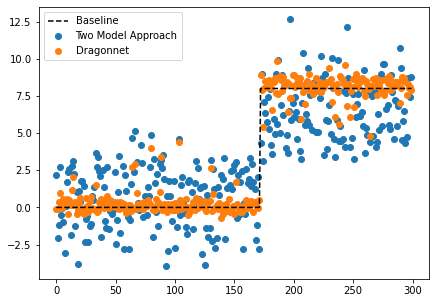

In [ ]:
### Comparison plot of 2 model and Dragonnet
from matplotlib import pyplot as plt
plt.figure(figsize=(7, 5))
plt.plot(np.arange(0,300,1), z['treatment_effect'], color='black', ls='--', label='Baseline')
plt.scatter(np.arange(0,300,1), z['CATE'], label="Two Model Approach")
plt.scatter(np.arange(0,300,1), z['CATE_Dragon'], label="Dragonnet")
plt.legend()



Above you can see compared to two model approach how good Dragonnet treatment effect estimates are. In our generated data True ITE is either equal to 0 or 8, which is represented by dashed line in the graphic. As you can see Dragonnet estimates have a significantly lower variance and they are mostly stationed around the true values. Although we cannot confirm Dragonnet is better by looking at QINI curves, the scatter plot above shows Dragonnet is superior to two model approach for estimating treatment effects.

In [ ]:
CATE_Dragon

In [ ]:
pd.DataFrame(CATE_Dragon).to_csv('CATE_Dragon.csv')


We have also used data from Infant Health and Development Program, which was used in the 'Adapting Neural Networks for the Estimation of Treatment Effects' paper.

In [ ]:
Y, T, X, expected_te = ihdp_surface_B()

In [ ]:
data=pd.DataFrame(np.column_stack([X, Y, T]))
data.rename(columns={26: "Y", 27: "T"},inplace=True)
cols=[0,	1,	2,	3,	4 ,5, 6,	7,	8,	9,	10,	11,	12,	13,	14,	15,	16,	17,	18,	19,	20,	21,	22,	23,	24,	25]

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(data, data['Y'], test_size=0.3)
n1=len(X_train[X_train['T'] == 1])
n0=len(X_train[X_train['T'] == 0])
df1 = X_train.loc[X_train['T'] == 1].sample(min(n0,n1)).reset_index()
df0 = X_train.loc[X_train['T'] == 0].sample(min(n0,n1)).reset_index()

X_train=pd.concat([df1,df0])
X_train = X_train.sample(frac=1).reset_index(drop=True)
X_train.drop('index', axis=1, inplace=True)

X_treatment=df1[cols]
Y_1=df1['Y']

X_control=df0[cols]
Y_0=df0['Y']

In [ ]:
model_t.fit(X_treatment,Y_1,callbacks=adam_callbacks, validation_split=0.2,epochs=30,batch_size=64,verbose=False)
model_c.fit(X_control,Y_0,callbacks=adam_callbacks, validation_split=0.2,epochs=30,batch_size=64,verbose=False)

In [ ]:
CATE_ihdp=model_t.predict(X_val[cols])-model_c.predict(X_val[cols])

In [ ]:
pd.DataFrame(CATE_ihdp).to_csv('CATE_ihdp.csv')
pd.DataFrame(y_val).to_csv('y_val_ihdp.csv')
pd.DataFrame(X_val['T']).to_csv('t_val_ihdp.csv')


In [ ]:
Dragon2 = DragonNet()

In [ ]:
Dragon2.fit_predict(X_train[cols],X_train['T'],X_train['Y'])

In [ ]:
CATE_Dragon_ihdp=Dragon2.predict_tau(X_val[cols])

In [ ]:
pd.DataFrame(CATE_Dragon_ihdp).to_csv('CATE_Dragon_ihdp.csv')